# Q-diamond plot

#### --- qiskit integration - grover ---

(authored by JK, AC Sep 28th, 2025)

This plotting routinge displays a n-qubit quantum state as a Hasse-type diagram with embedded probabilities. This is useful to debug algorithmic snippets of quantum circuits analytically.

In [1]:
import qmond_lib as qd
import matplotlib.pyplot as plt
%matplotlib inline

##### Conversion routing follows in the next cell. Note that this should ideally be in the Python library as already prepared, yet something's wrong with the Python environment at this point in time.

In [2]:
import numpy as np
from typing import Dict, Tuple, Iterable, Union

def probs_dict_to_subset_dict(probs_dict: Dict[str, float]) -> Dict[Tuple[int, ...], float]:
    """
    Convert Qiskit's probabilities_dict (bitstring keys) to a subset→value dict.

    Example: {"00": 0.5, "11": 0.5}  →  {(): 0.5, (0,1): 0.5}
    """
    out = {}
    for bitstring, p in probs_dict.items():
        n = len(bitstring)
        # Reverse order: bitstring[-1] = qubit 0, bitstring[-2] = qubit 1, etc.
        subset = tuple(i for i, bit in enumerate(reversed(bitstring)) if bit == "1")
        out[subset] = p
    return out

Subset = Tuple[int, ...]
AmpDict = Dict[Subset, complex]

def statevector_to_subset_dict(state: Union["Statevector", np.ndarray, Iterable[complex]],
                               eps: float = 0.0) -> AmpDict:
    """
    Convert a Qiskit Statevector (or 1D complex iterable) into a dict that maps
    'subset of qubit indices that are 1' -> complex amplitude.

    - Bit convention: bit j corresponds to qubit j (qubit 0 is least significant).
    - If eps > 0, amplitudes with |a| <= eps are dropped.
    """
    # Extract flat complex array
    if isinstance(state, Statevector):
        vec = np.asarray(state.data, dtype=complex)
        n = int(round(np.log2(vec.size)))
    else:
        vec = np.asarray(state, dtype=complex).ravel()
        n = int(round(np.log2(vec.size)))

    if vec.size != (1 << n):
        raise ValueError("Input length is not a power of two; expected a qubit statevector.")

    out: AmpDict = {}
    for i, a in enumerate(vec):
        if abs(a) <= eps:
            continue
        # subset = indices of qubits that are 1 in the basis state |b_{n-1} ... b_1 b_0>
        subset = tuple(j for j in range(n) if (i >> j) & 1)
        out[subset] = a
    return out

#### Integration with QisKit

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

from math import floor, pi, sqrt
def phase_oracle(qc: QuantumCircuit, bitstring: str):
    """
    Phase-flip the basis state matching `bitstring` (e.g. '101').
    Convention: rightmost char is qubit 0 (Qiskit standard print order).
    """
    n = len(bitstring)
    # Precondition so marked state becomes |11..1>
    for i, b in enumerate(reversed(bitstring)):  # map rightmost -> qubit 0
        if b == '0':
            qc.x(i)
    # Multi-controlled Z via H • MCX • H on the last qubit
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)  # for n>5 consider MCX modes/ancillas
    qc.h(n-1)
    # Uncompute preconditioning
    for i, b in enumerate(reversed(bitstring)):
        if b == '0':
            qc.x(i)

def diffusion(qc: QuantumCircuit):
    """Inversion about the mean on all qubits."""
    n = qc.num_qubits
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))

def grover_snapshots(n: int, marked: str):
    """
    Returns a list of (label, Statevector) pairs:
      [('iter 0 (uniform)', sv0), ('iter 1', sv1), ..., ('iter R', svR)]
    where R = floor(pi/4 * sqrt(2^n)) for a single marked item.
    """
    assert len(marked) == n and set(marked) <= {'0','1'}
    snapshots = []

    # Start in uniform superposition
    qc = QuantumCircuit(n)
    qc.h(range(n))
    snapshots.append(("iter 0 (uniform)", Statevector.from_instruction(qc)))

    # Grover iterations
    R = max(1, floor(pi/4 * sqrt(2**n)))
    for k in range(1, R+1):
        phase_oracle(qc, marked)
        diffusion(qc)
        snapshots.append((f"iter {k}", Statevector.from_instruction(qc)))

    return snapshots

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

h_spacing = 0.5
v_spacing = 2.0
size = [h_spacing, v_spacing]

def plot_grover_snapshots(n: int, marked: str,
                          prob_component: str = "abs",
                          cmap: str = "gray_r"):
    snaps = grover_snapshots(n, marked)

    cols = len(snaps)
    fig, axes = plt.subplots(1, cols, figsize=(3.3*cols, 3.8),
                             constrained_layout=True)

    # Shared colormap scale: for |z| use [0,1]
    # We'll add one shared colorbar at the end to keep things neat.
    for i, (label, sv) in enumerate(snaps):
        ax = axes[i] if cols > 1 else axes
        prob_subset = statevector_to_subset_dict(sv, eps=1e-12)  # amplitudes dict
        # Title with P(marked)
        p_marked = sv.probabilities_dict().get(marked, 0.0)
        ttl = f"{label}\nP({marked})={p_marked:.3f}"

        qd.plot_qbit_space(
            n=n,
            prob=prob_subset,
            prob_component=prob_component,  # "abs" | "real" | "imag" | "phase"
            cmap=cmap,
            tensor_bs_visible=1,
            edge_visible=0,
            show_colorbar=False,            # shared colorbar added once below
            title=ttl,
            tensor_bs_size = size,
            horizontal_spacing = h_spacing,
            vertical_spacing = v_spacing,
            fig=fig, 
            ax=ax
        )

    # Shared colorbar consistent with your function's scaling
    if prob_component == "abs":
        norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
        cblabel = "|z|"
    elif prob_component in ("real", "imag"):
        norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
        cblabel = "Re(z)" if prob_component == "real" else "Im(z)"
    else:
        norm = mpl.colors.Normalize(vmin=-pi, vmax=pi)
        cblabel = "arg(z) [rad]"

    sm = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.colormaps[cmap])
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes if cols > 1 else [axes], fraction=0.035, pad=0.06)
    cbar.set_label(cblabel, rotation=90)

    return fig, axes

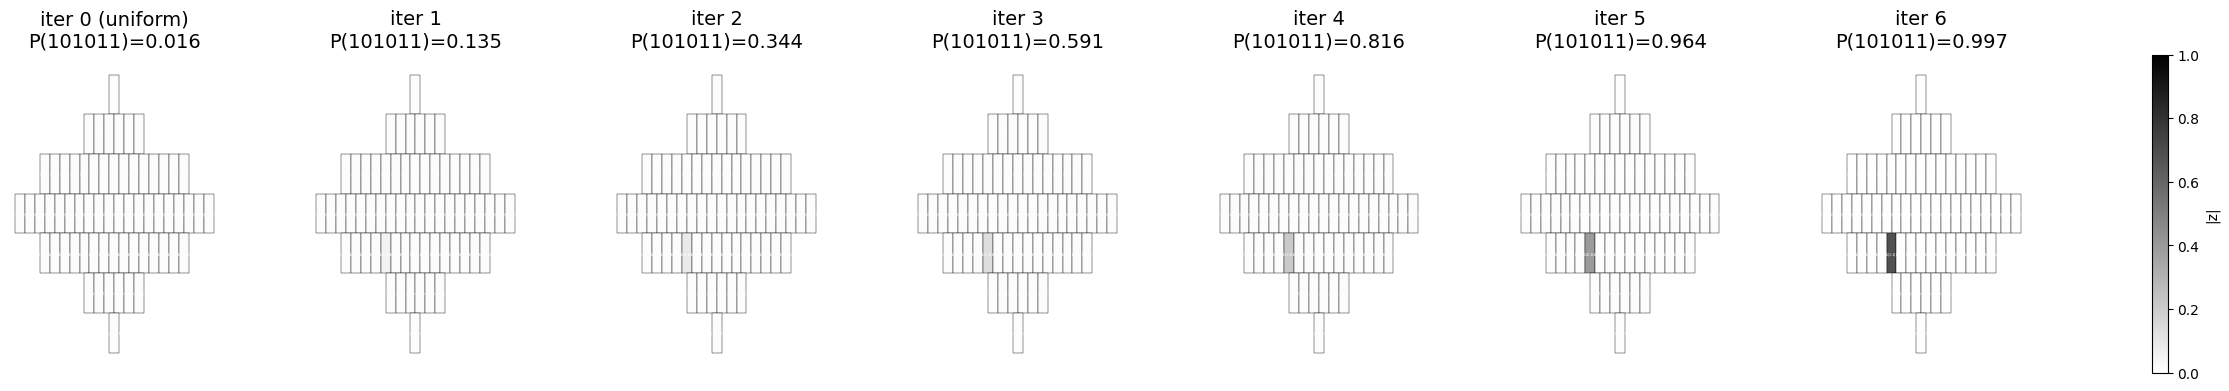

In [5]:
number_of_qubits = 6
marked = "101011"  # string uses print order: q2 q1 q0

fig, axes = plot_grover_snapshots(number_of_qubits, marked, prob_component="abs", cmap="gray_r")
plt.show()

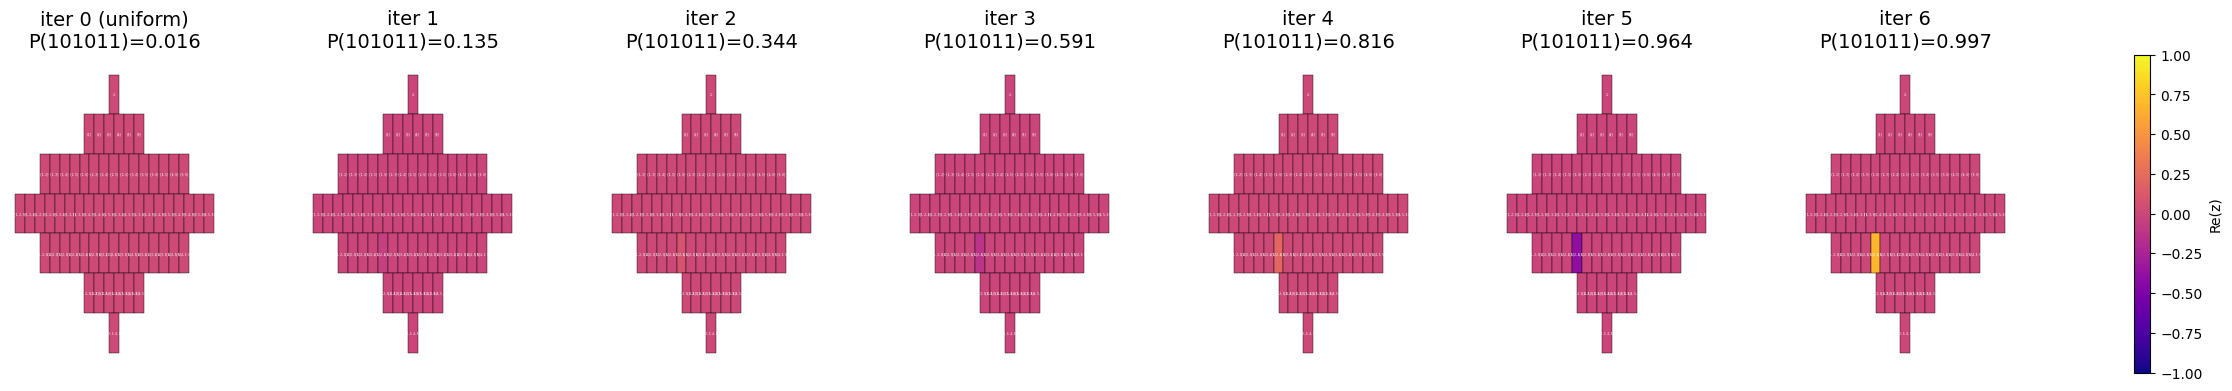

In [6]:
fig, axes = plot_grover_snapshots(number_of_qubits, marked, prob_component="real", cmap="plasma")
plt.show()